## 🤝 Run it on Google Colab

You can run _this chapter_ and play with it on Google Colaboratory: [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/AntonioCarta/avalanche-demo/blob/main/avl_e2e.ipynb)

https://github.com/AntonioCarta/avalanche-demo/blob/main/avl_e2e.ipynb

# Avalanche End-to-End Exampe

A basic example using Avalanche.

First, let's install Avalanche. You can skip this step if you have installed it already.

In [1]:
!pip install avalanche-lib==0.5.0

  Using cached setuptools-59.5.0-py3-none-any.whl (952 kB)
  Attempting uninstall: setuptools
    Found existing installation: setuptools 65.6.3
    Uninstalling setuptools-65.6.3:
      Successfully uninstalled setuptools-65.6.3


## Benchmarks

you can import benchmarks from the `avl.benchmarks` module.
We use task-aware SplitMNIST.

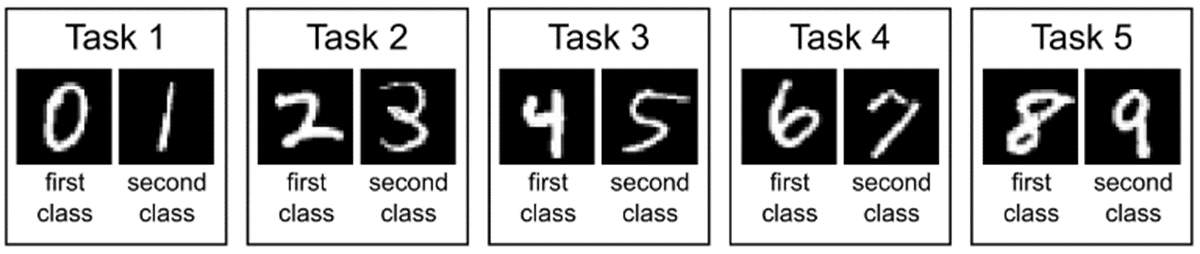

In [1]:
from avalanche.benchmarks import SplitMNIST

benchmark = SplitMNIST(
    n_experiences=5,
    return_task_id=True,
    seed=1
)
train_stream = benchmark.train_stream
test_stream = benchmark.test_stream

print(f"len train: {len(train_stream)}, len test: {len(test_stream)}")

for exp in train_stream:
    eid = exp.current_experience
    curr_classes = exp.classes_in_this_experience
    tid = exp.task_label
    print(f"({eid}) - T{tid}, classes={curr_classes}")

len train: 5, len test: 5
(0) - T0, classes=[5, 6]
(1) - T1, classes=[1, 2]
(2) - T2, classes=[0, 8]
(3) - T3, classes=[9, 3]
(4) - T4, classes=[4, 7]


# Multi-Head Model
we use a multihead model:
- shared feature extractor
- one classification head for each task (created on-demand)

In [2]:
import torch
from torch import nn
from avalanche.models import as_multitask

class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU()
        )
        self.classifier = nn.Linear(512, 10)
    
    def forward(self, x, **kwargs):
        x = x.reshape(x.shape[0], -1)
        x = self.features(x)
        return self.classifier(x)
    
model = MLP()
model = as_multitask(MLP(), 'classifier')
print(model)

MultiTaskDecorator(
  (model): MLP(
    (features): Sequential(
      (0): Linear(in_features=784, out_features=512, bias=True)
      (1): ReLU()
      (2): Linear(in_features=512, out_features=512, bias=True)
      (3): ReLU()
    )
    (classifier): Sequential()
  )
  (classifier): MultiHeadClassifier(
    (classifiers): ModuleDict(
      (0): IncrementalClassifier(
        (classifier): Linear(in_features=512, out_features=10, bias=True)
      )
    )
  )
)


# Device, Optimizer, Criterion
these are pytorch objects

In [3]:
from torch.optim import SGD

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
optimizer = SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss()

# EvaluationPlugin
choose the metrics and loggers

In [4]:
from avalanche.evaluation.metrics import accuracy_metrics, timing_metrics
from avalanche.logging import InteractiveLogger
from avalanche.training.plugins import EvaluationPlugin

# print to stdout
interactive_logger = InteractiveLogger()

eval_plugin = EvaluationPlugin(
    accuracy_metrics(epoch=True, experience=True, stream=True),
    timing_metrics(epoch=True),
    loggers=[interactive_logger]
)

# CL Strategy

In [6]:
from avalanche.training import Naive

cl_strategy = Naive(
    model=model, 
    optimizer=optimizer, 
    criterion=criterion, 
    train_mb_size=32, train_epochs=2,
    eval_mb_size=32, device=device,
    evaluator=eval_plugin
)

# Training and Evaluation Loop

In [7]:
# train and test loop over the stream of experiences
results = []
for train_exp in train_stream:
    cl_strategy.train(train_exp)
    results.append(cl_strategy.eval(test_stream))

-- >> Start of training phase << --
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 355/355 [00:05<00:00, 68.44it/s]
Epoch 0 ended.
	Time_Epoch/train_phase/train_stream/Task000 = 5.2105
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9477
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 355/355 [00:04<00:00, 73.12it/s]
Epoch 1 ended.
	Time_Epoch/train_phase/train_stream/Task000 = 4.8533
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9795
-- >> End of training phase << --
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:00<00:00, 100.00it/s]
> Eval on experien

In [8]:
results

[{'Top1_Acc_Epoch/train_phase/train_stream/Task000': 0.979539641943734,
  'Time_Epoch/train_phase/train_stream/Task000': 4.853341500042006,
  'Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000': 0.981081081081081,
  'Top1_Acc_Exp/eval_phase/test_stream/Task001/Exp001': 0.0,
  'Top1_Acc_Exp/eval_phase/test_stream/Task002/Exp002': 0.5015353121801432,
  'Top1_Acc_Exp/eval_phase/test_stream/Task003/Exp003': 0.0,
  'Top1_Acc_Exp/eval_phase/test_stream/Task004/Exp004': 0.0,
  'Top1_Acc_Stream/eval_phase/test_stream/Task004': 0.2795},
 {'Top1_Acc_Epoch/train_phase/train_stream/Task000': 0.979539641943734,
  'Time_Epoch/train_phase/train_stream/Task000': 4.853341500042006,
  'Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000': 0.9372972972972973,
  'Top1_Acc_Exp/eval_phase/test_stream/Task001/Exp001': 0.991693585602215,
  'Top1_Acc_Exp/eval_phase/test_stream/Task002/Exp002': 0.5015353121801432,
  'Top1_Acc_Exp/eval_phase/test_stream/Task003/Exp003': 0.0,
  'Top1_Acc_Exp/eval_phase/test_strea

In [9]:
cl_strategy.evaluator.get_all_metrics()

defaultdict(<function avalanche.training.plugins.evaluation._init_metrics_list_lambda()>,
            {'Top1_Acc_Epoch/train_phase/train_stream/Task000': ([355, 710],
              [0.947702619278596, 0.979539641943734]),
             'Time_Epoch/train_phase/train_stream/Task000': ([355, 710],
              [5.210541600128636, 4.853341500042006]),
             'Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000': ([710,
               1504,
               2240,
               2996,
               3754],
              [0.981081081081081,
               0.9372972972972973,
               0.9513513513513514,
               0.9383783783783783,
               0.9481081081081081]),
             'Top1_Acc_Exp/eval_phase/test_stream/Task001/Exp001': ([710,
               1504,
               2240,
               2996,
               3754],
              [0.0,
               0.991693585602215,
               0.9672358098754038,
               0.9746192893401016,
               0.974619289340101

Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000
Top1_Acc_Exp/eval_phase/test_stream/Task001/Exp001
Top1_Acc_Exp/eval_phase/test_stream/Task002/Exp002
Top1_Acc_Exp/eval_phase/test_stream/Task003/Exp003
Top1_Acc_Exp/eval_phase/test_stream/Task004/Exp004


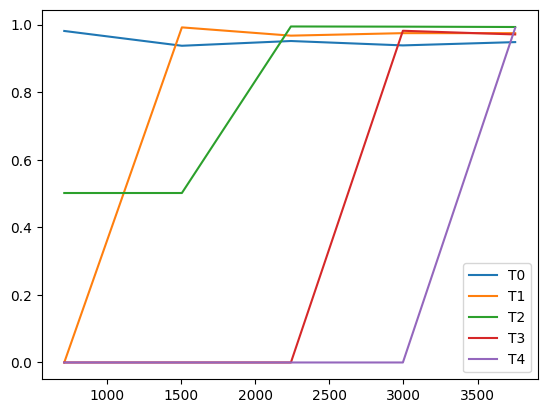

In [16]:
import matplotlib.pyplot as plt
allres = cl_strategy.evaluator.get_all_metrics()
for tid in range(5):
    mname = f"Top1_Acc_Exp/eval_phase/test_stream/Task00{tid}/Exp00{tid}"
    print(mname)
    plt.plot(allres[mname][0], allres[mname][1], label=f"T{tid}")
plt.legend()